# Business Problem 

A bank would like to increase their revenue by having more of their clients subscribe to long-term deposits. The bank aims to identify which of their existing clients have higher chances of subscribing to long-term deposits when they are contacted through a telemarketing campaign. This information would help the bank to improve their conversion rate (more customers subscribing to long-term deposits from of a fixed number of calls made) by:

- Concentrating their telemarketing efforts on clients more likely to subscribe.
- Planning details of future telemarketing campaigns that are more likely to succeed.

# Data Science Problem

The bank marketing dataset contains historic data collected from direct telemarketing campaigns of a Portuguese retail bank to their clients to sell long-term deposits, along with outcomes for each client (success/failure). We can therefore train a machine learning model that takes this information as input features, and predict the binary outcome of whether a client will subscribe to the long-term deposit or not.

# Table of contents

- [Dataset exploration](#dataset_exploration)
    - [Import libraries](#import_libraries)
    - [Load dataset](#load_dataset)
    - [Feature descriptions](#feature_descriptions)
    - [Target variable](#target_variables)
    - [Check numerical and categorical features](#check_features)
    - [Check for any missing data](#missing_data)
    - [Check class distribution in the target variable](#class_distribution)
- [Data visualization](#data_viz)
    - [Univariate analysis of categorical features](#univariate_categorical)
    - [Observations](#observations1)
    - [Bivariate analysis of categorical features](#bivariate_categorical)
    - [Observations](#observations2)
    - [Univariate analysis of numerical features](#univariate_numerical)
    - [Observations](#observations3)
- [Data preprocessing pipeline](#data_preprocessing)
    - [Preprocess categorical features](#preprocessing_categorical)
        - [Impute unknown values from categorical columns](#impute_unknown)
        - [Encode categorical variables and the target](#encoding_categorical)
            - [One-hot encoding of nominal categorical features](#encoding_nominal)
            - [Encoding of cyclic ordinal features](#encoding_ordinal)
    - [Preprocess numerical features](#preprocessing_numerical)
        - [Drop non-informative features](#drop_features)
        - [Treat outliers in the numerical features](#treat_outliers)
    - [Split dataset into train and test sets](#split_dataset)
    - [Scale numerical features](#scale_numerical)

# Dataset exploration <a name="dataset_exploration"></a>

## Import libraries <a name="import_libraries"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Load dataset <a name="load_dataset"></a>

In [2]:
path = '../data/bank-additional-full.csv'
df = pd.read_csv(path,delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
print(f'The dataset has {len(df)} records from past telemarketing campaigns.')
print(f'Each record has {df.shape[1]-1} features and the last column in the dataframe indicates the outcome of the campaign (subscribed or not subscribed).')

The dataset has 41188 records from past telemarketing campaigns.
Each record has 20 features and the last column in the dataframe indicates the outcome of the campaign (subscribed or not subscribed).


## Feature descriptions <a name="feature_descriptions"></a>

|Feature|Feature Type|Description|
|-----|-----|-----|
|age|Numeric|Age of the client|
|job|Categorical, Nominal|Job held by the client ('admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management','retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')|
|marital|Categorical, Nominal|Marital status of the client ('divorced', 'married', 'single', 'unknown'; note: 'divorced' includes divorced and widowed)|
|education|Categorical, Nominal|Educational qualification of the client ('basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')|
|default|Categorical, Nominal|Does client have credit in default? ('no', 'yes', 'unknown')|
|housing|Categorical, Nominal|Does client have a housing loan? ('no', 'yes', 'unknown')|
|loan|Categorical, Nominal|Does client have a personal loan? ('no', 'yes', 'unknown')|
|contact|Categorical, Nominal|How was the client contacted ('telephone', 'cellular')|
|month|Categorical, Ordinal|Month of year of last contact ('jan', 'feb', 'mar', ..., 'nov', 'dec)|
|day_of_week|Categorical, Ordinal|Day of week of last contact ('mon', 'tue', 'wed', 'thu', 'fri')|
|duration|Numeric|Duration in seconds of last contact|
|campaign|Numeric|Number of times the client was contacted during this campaign (includes last contact)|
|pdays|Numerical|Number of days since the client was last contacted for a previous campaign; 999 means client was not contacted previously|
|previous|Numeric|Number of times client was contacted before this campaign|
|poutcome|Categorical, Nominal|Outcome of the previous marketing campaign (failure', 'nonexistent', 'success')|
|emp.var.rate|Numeric|Employment variation rate, quarterly indicator|
|cons.price.idx|Numeric|Consumer price index, monthly indicator|
|cons.conf.idx|Numeric|Consumer confidence index, monthly indicator|
|euribor3m|Numeric|Euribor 3 month rate, monthly indicator|
|nr.employed|Numeric|Number of employees, quarterly indicator|

So, the features can be broadly divided into the following 3 categories:

- **Client data:** Features related to the client, e.g. age, job, marital status, education, default status, housing and personal loan status.
- **Campaign data:** Features related to the current and previous campaigns, e.g. communication type, month and day of week of last contact, duration of last contact, number of contacts during current campaign, number of days since last contact for a previous campaign, number of contacts before current campaign and outcome of previous campaign.
- **Economy data:** Features related to the economic attributes, e.g.employment variation rate, consumer price index, consumer confidence index, euribor 3 month rate and number of employees.

## Target variable <a name="target_variable"></a>

|Target|Type|Description|
|-----|-----|-----|
|y|Binary|Has the client subscribed to a long-term deposit? ('yes', 'no')|

## Check numerical and categorical features <a name="check_features"></a>

In [4]:
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
print('The numerical features are:')
df[numerical_columns].head()

The numerical features are:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [5]:
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()
categorical_columns.remove('y')
print('The categorical features are:')
df[categorical_columns].head()

The categorical features are:


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


## Check for any missing data <a name="missing_data"></a>

In [6]:
# Returns total number of missing values and percentage of missing values for each column in the dataframe
def count_missing_values(dataframe):
    
    total = dataframe.isnull().sum()
    percent = (dataframe.isnull().sum())/(len(dataframe))
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data

missing_data = count_missing_values(df)
print(missing_data)

                Total  Percent
age                 0      0.0
job                 0      0.0
marital             0      0.0
education           0      0.0
default             0      0.0
housing             0      0.0
loan                0      0.0
contact             0      0.0
month               0      0.0
day_of_week         0      0.0
duration            0      0.0
campaign            0      0.0
pdays               0      0.0
previous            0      0.0
poutcome            0      0.0
emp.var.rate        0      0.0
cons.price.idx      0      0.0
cons.conf.idx       0      0.0
euribor3m           0      0.0
nr.employed         0      0.0
y                   0      0.0


The dataset does not have any missing values in any of the columns. So we would not have to worry about dropping any rows or imputing the missing values.

## Check for duplicate rows

In [7]:
l0 = df.shape[0]
df.drop_duplicates(inplace=True)
l1 = df.shape[0]
print(f'{l0-l1} rows were dropped.')

12 rows were dropped.


## Check class distribution in the target variable <a name="class_distribution"></a>

In [8]:
class_distribution = (df['y'].value_counts()/df['y'].value_counts().sum())*100
print(class_distribution)

no     88.733728
yes    11.266272
Name: y, dtype: float64


So the dataset is heavily imbalanced. Almost 89% of the clients from the telemarketing campaign records did not subscribe to long-term deposits.

# Data visualization <a name="data_viz"></a>

## Univariate analysis of categorical features <a name="univariate_categorical"></a>

Here, we will look at the distribution of unique values for each categorical feature in the dataset.

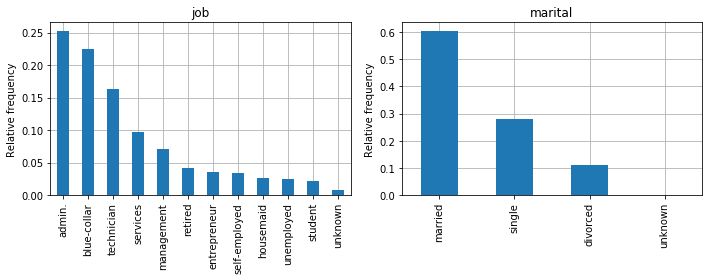

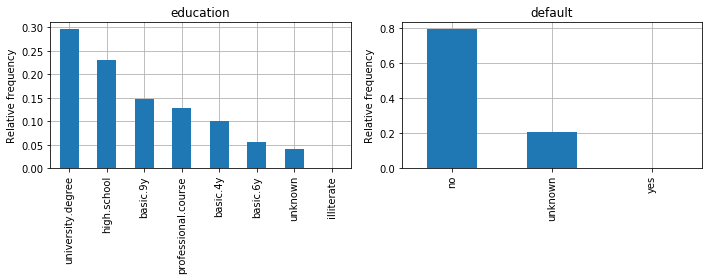

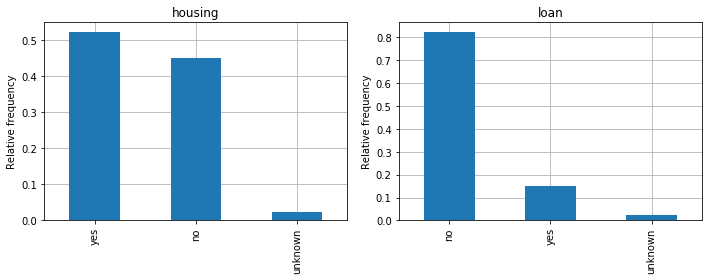

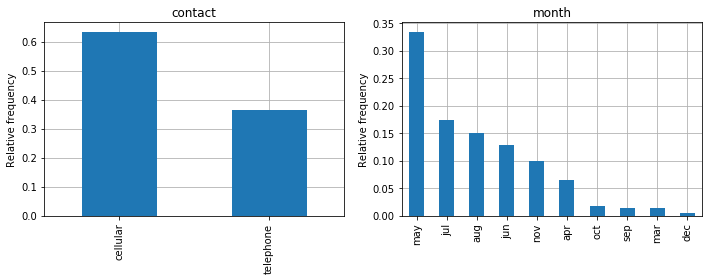

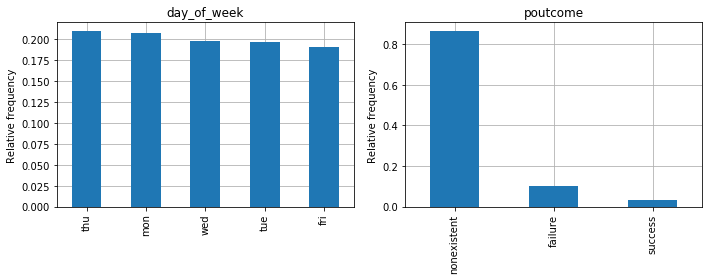

In [9]:
plt.rcParams['axes.axisbelow'] = True
for i in range(0, len(categorical_columns), 2):
    if i!=len(categorical_columns)-1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        df[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar')
        plt.title(categorical_columns[i])
        plt.ylabel('Relative frequency')
        plt.tight_layout()
        plt.grid(True)
        plt.subplot(122)
        df[categorical_columns[i+1]].value_counts(normalize=True).plot(kind='bar')
        plt.title(categorical_columns[i+1])
        plt.ylabel('Relative frequency')
        plt.tight_layout()
        plt.grid(True)
    else:
        df[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar')
        plt.title(categorical_columns[i])
        plt.ylabel('Relative frequency')

## Observations: <a name="observations1"></a>

- Most of the clients have administrative, blue collar, technician or service jobs.
- Almost 60% of the clients are married.
- More than 50% of the clients hold high-school or university degrees. Almost none are illiterate.
- 80% of the clients have not defaulted.
- There is an almost even breakdown of people who have housing loans and people who do not, although almost 80% of the people do not have a personal loan.
- More than 60% of the people were contacted via cellular phone.
- Most of the calls were placed over the summer months (May - August).
- Calls were evenly distributed from Monday to Friday.
- More than 85% of the people were not contacted in the marketing campaign prior to when the data was collected.

## Bivariate analysis of categorical features <a name="bivariate_categorical"></a>

We plot each categorical feature against the target labels using a barchart.

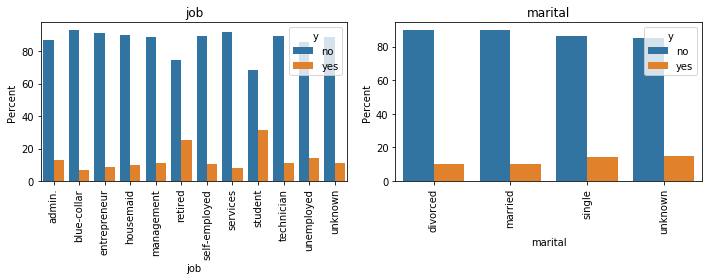

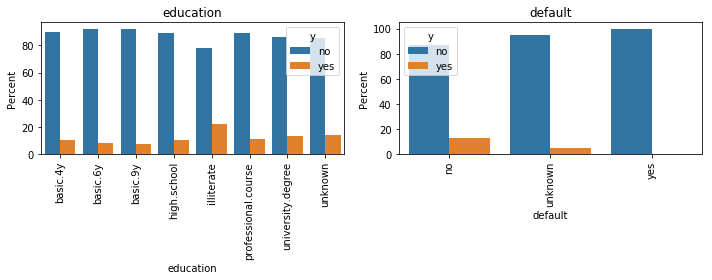

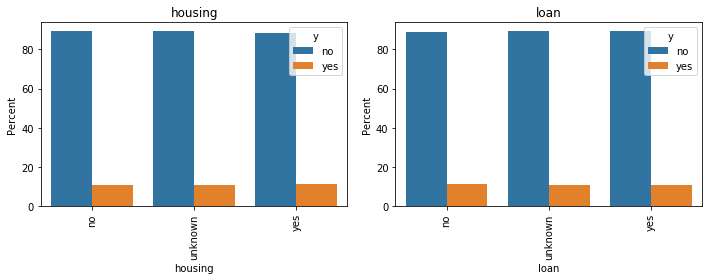

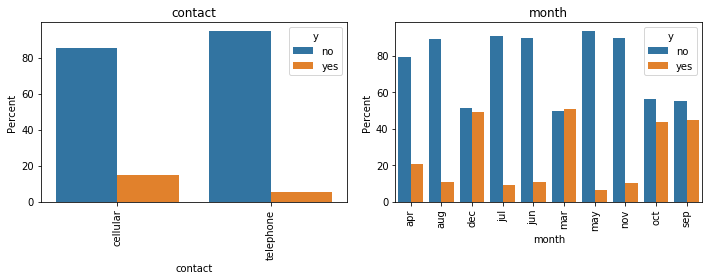

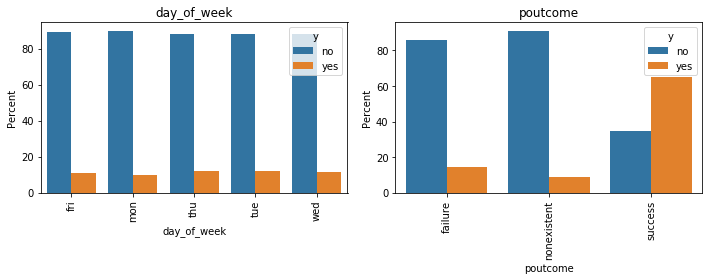

In [10]:
%matplotlib inline
for i in range(0, len(categorical_columns), 2):
    if i!=len(categorical_columns)-1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        x,y = categorical_columns[i], 'y'
        (df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('Percent').reset_index().pipe((sns.barplot,'data'), x=x, y='Percent',hue=y))
        plt.title(categorical_columns[i])
        plt.xticks(rotation=90);
        plt.subplot(122) 
        x,y = categorical_columns[i+1], 'y'
        (df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('Percent').reset_index().pipe((sns.barplot,'data'), x=x,y='Percent',hue=y))
        plt.title(categorical_columns[i+1])
        plt.xticks(rotation=90);
        plt.tight_layout()
    else:
        x,y = categorical_columns[i], 'y'
        (df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('Percent').reset_index().pipe((sns.barplot,'data'), x=x,y='Percent',hue=y))
        plt.title(categorical_columns[i])
        plt.xticks(rotation=90);

## Observations: <a name="observations2"></a>

- Retired people and students have a better chance of subscribing (around 30%).
- Marital status does not seem to affect the target variable.
- Illiterate people, closely followed by people with university degrees or professional courses have more chances of subscribing.
- Everyone who subscribed has never defaulted, which is not surprising.
- Having a housing or personal loan does not, by itself, affect whether a customer will subscribe or not.
- Customers reached over cellular phone are more likely to subscribe.
- Customers contacted in the months of March, September, October or December have a high conversion rate (almost 50%).
- Day of week when a client is contacted does not seem to affect the target variable.
- If the previous marketing campaign succeeded in having a client subscribe, chances are the current campaign will too.

## Univariate analysis of numerical features <a name="univariate_numerical"></a>

We will use histograms for plotting the distribution of each numerical feature.

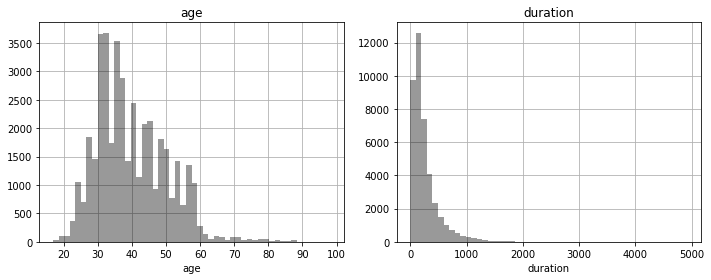

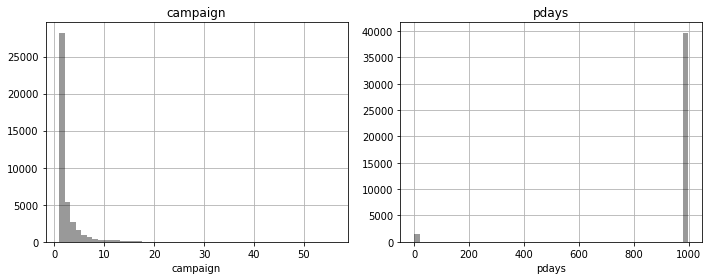

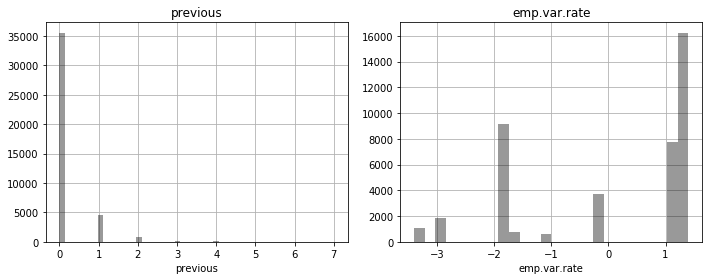

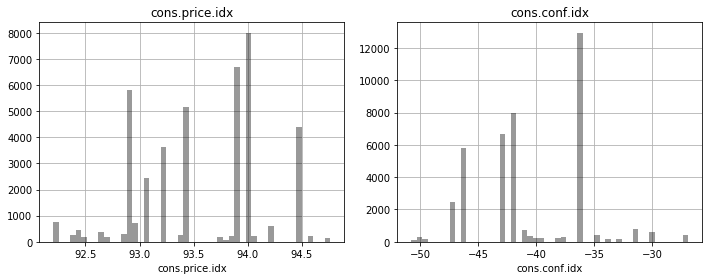

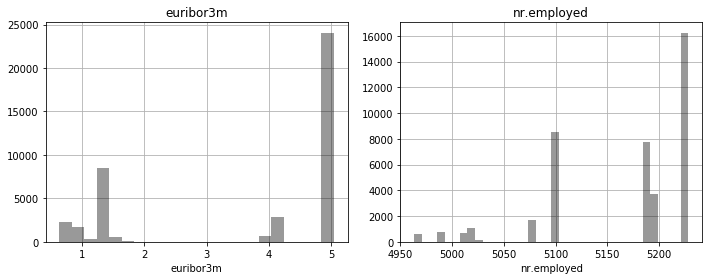

In [11]:
for i in range(0, len(numerical_columns), 2):
    if i!=len(numerical_columns)-1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.distplot(df[numerical_columns[i]], kde=False, color='k')
        plt.title(numerical_columns[i])
        plt.grid(True)
        plt.subplot(122)            
        sns.distplot(df[numerical_columns[i+1]], kde=False, color='k')
        plt.title(numerical_columns[i+1])
        plt.tight_layout()
        plt.grid(True)
        plt.show()
    else:
        sns.distplot(df[numerical_columns[i]], kde=False, color='k')
        plt.title(numerical_columns[i])
        plt.grid(True)

## Observations: <a name="observations3"></a>

- Most of the customers are between 30 and 40 years of age.
- Most of the calls placed were 0-200 seconds in duration.
- Most of the clients were contacted between 1-3 times in the current campaign.
- Less than 5% of the clients were contacted in the previous campaign ('pdays'=999 means client was not previously contacted). So this feature has very little variance and is not informative at all.
- Almost 88% of the clients were not contacted before this campaign. So the feature 'previous' also has very little variance and not much information.

So, we can safely drop 'pdays' and 'previous' features. Furthermore, if the goal is to have a realistic predictive model, we should also drop the 'duration' feature, because of the following 2 reasons:

1. When we put the model in deployment, it is not possible for us to know the call duration for a client before the call has been placed. So if our aim is to build a model that can realistically predict if a client will subscribe, call duration should not be an input feature.
2. If we do wait until the end of the call to know the call duration, we would also get to know the outcome of the call (success/failure),so there is no point in having a machine learning model to predict the outcome.

# Data preprocessing pipeline <a name="data_preprocessing"></a>

## Preprocess categorical features <a name="preprocessing_categorical"></a>

### Impute unknown values from categorical columns <a name="impute_unknown"></a>

Values marked 'unknown' are present in a few categorical columns, including job, marital, education, default, housing and loan. None of these columns have more than 5% of their values marked 'unknown' though. We will impute these values with the mode (most frequently occurring element) of the corresponding categorical column.

In [12]:
for column in categorical_columns:
    df[column] = df[column].str.replace('unknown', df[column].mode()[0])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Encode categorical variables and the target <a name="encoding_categorical"></a>

We have 10 categorical features, out of which 8 are nominal, i.e., their values do not have a sense of order. We can use one-hot encoding to encode these features.

Two features, however, are ordinal in nature - month and day of week. But although there is a sense of ordering among their values (e.g. January is always followed by February and Monday by Tuesday), these features are also cyclic in nature, i.e., December is followed by January again and Sunday by Monday. Merely label encoding these two variables would not retain information about this cyclic nature. So for these two features, we use cyclic feature engineering, i.e., take the sine and cosine transformations of the label-encoded features, thereby preserving the cyclic nature of the variables.

Finally, we also encode the target values ('yes' to 1 and 'no' to -1). Although this is not strictly necessary for training the machine learning models, they would make things easier for us when we calculate accuracy metrics.

**One-hot encoding of nominal categorical features** <a name="encoding_nominal"></a>

In [13]:
for column in categorical_columns:
    if column not in set(('month', 'day_of_week')):
        dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
        df = pd.concat([df, dummies],axis=1)
        df.drop(column, axis=1, inplace=True)

In [14]:
df.columns

Index(['age', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_married', 'marital_single', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

**Encoding of cyclic ordinal features** <a name="encoding_ordinal"></a>

In [15]:
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [16]:
df['day_of_week'].unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

Not all months or days of the week are present here, so we first encode all 12 months into labels 1,...,12, and all days of the week into labels 1,...,7, using a dictionary. Then we compute the sine and cosine transformations of the label-encoded values. These are the x and y co-ordinates of the point on an unit circle, ensuring 

In [17]:
month_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df['month'] = df['month'].map(month_dict)
df['month'].unique()

array([ 5,  6,  7,  8, 10, 11, 12,  3,  4,  9])

In [18]:
day_dict = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}
df['day_of_week'] = df['day_of_week'].map(day_dict)
df['day_of_week'].unique()

array([1, 2, 3, 4, 5])

In [19]:
df['y'] = df['y'].map({'yes':1, 'no':-1})

## Preprocess numerical features <a name="preprocessing_numerical"></a>

### Drop non-informative features <a name="drop_features"></a>

In [20]:
df.drop(['pdays', 'previous', 'duration'], 1, inplace=True)
numerical_columns.remove('pdays')
numerical_columns.remove('previous')
numerical_columns.remove('duration')
df.head()

,age,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,56,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,0,0,0,0,0,0,1,1,0
1,57,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,1,0,0,0,0,0,0,1,1,0
2,37,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,1,0,0,0,0,1,0,1,1,0
3,40,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,0,0,0,0,0,0,1,1,0
4,56,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,1,0,0,0,0,0,1,1,1,0


### Treat outliers in the numerical features <a name="treat_outliers"></a>

The histograms show some of the numerical features (particularly, 'age', 'campaign', etc.) have outliers. We can use **Winsorization** of the bottom 5% and top 5% of data points for example, which replaces all values below the 5th percentile with the value at 5th percentile and all values above 95th percentile with the value at 95th percentile.

Before treating outliers:


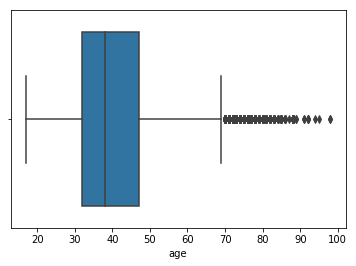

In [21]:
print('Before treating outliers:')
sns.boxplot(df['age']);

In [22]:
for column in numerical_columns:
    df[column] = winsorize(df[column], limits=[0.05, 0.05])

After treating outliers:


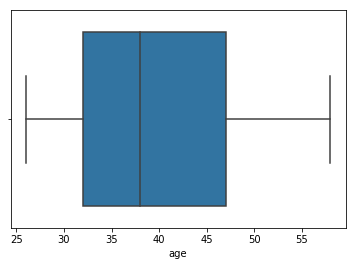

In [23]:
print('After treating outliers:')
sns.boxplot(df['age']);

## Split dataset into training and test sets <a name="split_dataset"></a>

In [24]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Scale numerical features <a name="scale_numerical"></a>

In [25]:
scaler = preprocessing.StandardScaler().fit(train[numerical_columns])
train[numerical_columns] = scaler.transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

In [26]:
print(f'The final number of features for each record is {df.shape[1]-1}.')

The final number of features for each record is 33.


In [27]:
# Save processed training and test datasets
train.to_csv(r'../data/processed-train.csv', index=False)
test.to_csv(r'../data/processed-test.csv', index=False)